In [1]:
# Install the pycoco library
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272462 sha256=29b6431250311e37fa40a980e22458ad41b3afd91a77153c0207deb0cbab292d
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import random
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline
import imgaug.augmenters as iaa

In [3]:
# Set important parameters
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 300
EPOCHS = 10

In [4]:
# Define the image and annotation paths
train_imgs_path = '../input/food-recognition-challenge/train-v0.4/train/images'
train_anns_path = '../input/food-recognition-challenge/train-v0.4/train/annotations.json'

val_imgs_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

test_imgs_path = '../input/food-recognition-challenge/test_images-v0.4/val/images'
test_anns_path = '../input/food-recognition-challenge/test_images-v0.4/val/annotations.json'

In [5]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'ID', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [catID] + [len(imgIds)]
    
    return coco, df

In [6]:
# Load the annotations of the image dataset
train_coco, train_classes = getCOCO(train_anns_path)
val_coco, val_classes = getCOCO(val_anns_path)
test_coco, test_classes = getCOCO(test_anns_path)

loading annotations into memory...
Done (t=4.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [7]:
def getMask(image_id, coco, classes, image_size):
    # Create a zero array with the given size and number of classes
    mask = np.zeros((image_size[0], image_size[1], 274))

    annIds = coco.getAnnIds(int(image_id))
    anns = coco.loadAnns(annIds)

    for i, ann in enumerate(anns):
        # Get the binary mask for the annotation
        binary = cv2.resize(coco.annToMask(ann), image_size)

        # Get the channel index for the annotation
        channel = classes[classes.ID == ann['category_id']].index[0] + 1

        # Update the channel of the annotation
        mask[:, :, channel] = binary

        # Update the background channel of the annotation
        if i == 0:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
        else:
            mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

    return mask

In [8]:
def getGenerator(path, coco, classes, image_size, batch_size, augment=False):
    c = 0
    n = os.listdir(path)
    random.shuffle(n)
    
    geo_aug = iaa.Fliplr(1.0)
    
    while (True):
        img_batch = np.zeros((batch_size, image_size[0], image_size[1], 3)).astype('int')
        mask_batch = np.zeros((batch_size, image_size[0], image_size[1], 274)).astype('float')

        for i in range(c, c + batch_size):
            img = cv2.imread(path + '/' + n[i])
            img =  cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask = getMask(n[i][1:-4], coco, classes, image_size)
            
            if augment == True:
                if random.randrange(10) % 2 == 0:
                    img = geo_aug(image=img)
                    mask = geo_aug(image=mask)            
            
            img_batch[i-c] = img
            mask_batch[i-c] = mask

        c += batch_size
        if(c + batch_size >= len(os.listdir(path))):
            c = 0
            random.shuffle(n)

        yield img_batch, mask_batch

In [9]:
# Get the generators from the paths
train_gen = getGenerator(train_imgs_path, train_coco, train_classes, IMAGE_SIZE, BATCH_SIZE, True)

train_length = len(os.listdir(train_imgs_path))
print('Number of training images: {}'.format(train_length))

val_gen = getGenerator(val_imgs_path, val_coco, val_classes, IMAGE_SIZE, BATCH_SIZE)

val_length = len(os.listdir(val_imgs_path))
print('Number of validation images: {}'.format(val_length))

test_gen = getGenerator(test_imgs_path, test_coco, test_classes, IMAGE_SIZE, BATCH_SIZE)

test_length = len(os.listdir(test_imgs_path))
print('Number of test images: {}'.format(test_length))

Number of training images: 24120
Number of validation images: 1269
Number of test images: 1269


In [10]:
def visualise(path, coco, classes, image_size, batch_size, augment=False):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size, augment)
    images, masks = next(temp_gen)
    
    for i in range(batch_size):
        plt.figure(figsize=(10, 20))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Background Channel')
        plt.imshow(masks[i][:, :, 0])
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Max of Object Channels')
        plt.imshow(np.max(masks[i][:, :, 1:], axis=2))
        plt.axis('off')
        
        plt.show()

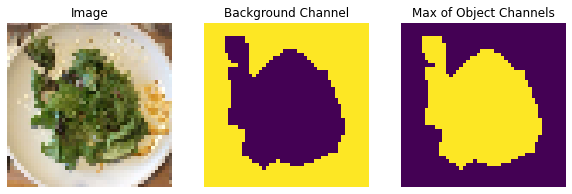

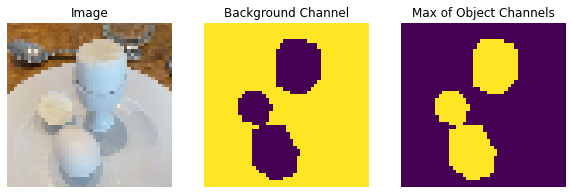

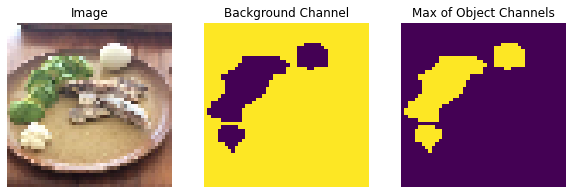

In [11]:
# Visualise a few samples images with their backgrounds and objects
visualise(train_imgs_path, train_coco, train_classes, IMAGE_SIZE, 3, True)

In [12]:
# Install and import the segmentation models library
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 1.7 MB/s eta 0:00:01
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [13]:
# Define the model to be trained
model = sm.PSPNet('efficientnetb7', encoder_weights='imagenet', encoder_freeze=True, 
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), downsample_factor=4, 
                  classes=274, activation='softmax')

model.compile('Adam', loss=sm.losses.cce_dice_loss, 
              metrics=[sm.metrics.IOUScore(), sm.metrics.Precision(), sm.metrics.Recall()])

258441216/258434480 [==============================] - 3s 0us/step


In [14]:
# # Load the trained model weights
# weights_path = '../input/food-recognition-model/weights.h5'
# model.load_weights(weights_path)

In [15]:
# Train the defined model on the dataset
history = model.fit(train_gen, steps_per_epoch=train_length//BATCH_SIZE, 
                    validation_data=val_gen, validation_steps=val_length//BATCH_SIZE, 
                    epochs=EPOCHS)

/opt/conda/lib/python3.7/site-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (48, 48, 274) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 1/10
80/80 [==============================] - 734s 9s/step - loss: 0.9945 - iou_score: 0.0090 - precision: 0.0171 - recall: 0.3765 - val_loss: 1.0091 - val_iou_score: 0.0077 - val_precision: 0.0401 - val_recall: 0.3676
Epoch 2/10
80/80 [==============================] - 464s 6s/step - loss: 0.9584 - iou_score: 0.0314 - precision: 0.0689 - recall: 0.4076 - val_loss: 0.9932 - val_iou_score: 0.0127 - val_precision: 0.0826 - val_recall: 0.3478
Epoch 3/10
80/80 [==============================] - 454s 6s/step - loss: 0.9378 - iou_score: 0.0468 - precision: 0.1005 - recall: 0.4333 - val_loss: 0.9522 - val_iou_score: 0.0436 - val_precision: 0.1239 - val_recall: 0.3891
Epoch 4/10
80/80 [==============================] - 451s 6s/step - loss: 0.8935 - iou_score: 0.0884 - precision: 0.1789 - recall: 0.4539 - val_loss: 0.8288 - val_iou_score: 0.1617 - val_precision: 0.3169 - val_recall: 0.4324
Epoch 5/10
80/80 [==============================] - 1087s 14s/step - loss: 0.7772 - iou_score: 0.204

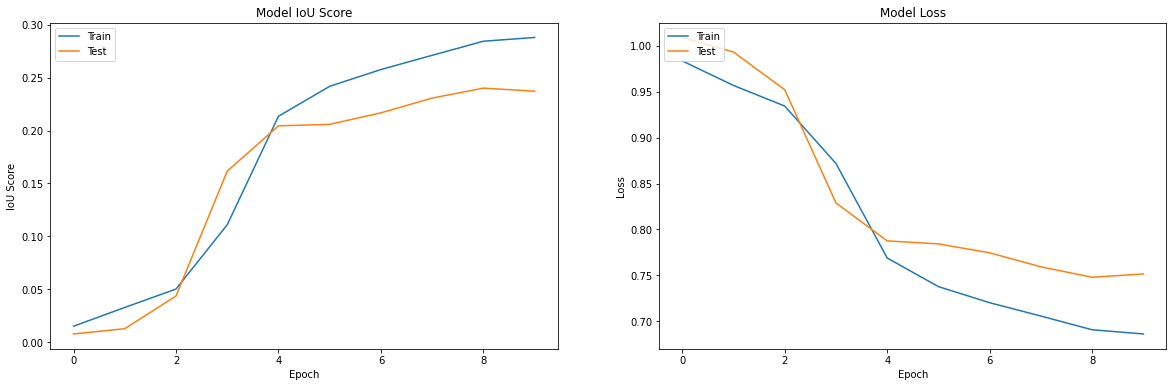

In [16]:
# Plot the loss and iou score over the epochs
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IoU Score')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# Save the model to the output
model.save_weights('weights.h5')

In [18]:
# Evaluate the model on the test generator
scores = model.evaluate(test_gen, steps=test_length//BATCH_SIZE)
print('\nLoss: {}'.format(round(scores[0], 3)))
print('Average IoU: {}'.format(round(scores[1], 3)))
print('Average Precision: {}'.format(round(scores[2], 3)))
print('Average Recall: {}'.format(round(scores[3], 3)))

4/4 [==============================] - 27s 9s/step - loss: 0.7527 - iou_score: 0.2364 - precision: 0.5036 - recall: 0.4339

Loss: 0.753
Average IoU: 0.236
Average Precision: 0.504
Average Recall: 0.434


In [19]:
def predict(model, path, coco, classes, image_size, batch_size):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size)
    images, masks = next(temp_gen)
    prediction = model.predict(images)
    
    for i in range(batch_size):
        plt.figure(figsize=(10, 20))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(np.max(masks[i][:, :, 1:], axis=2))
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(np.max(prediction[i][:, :, 1:], axis=2))
        plt.axis('off')
        
        plt.show()

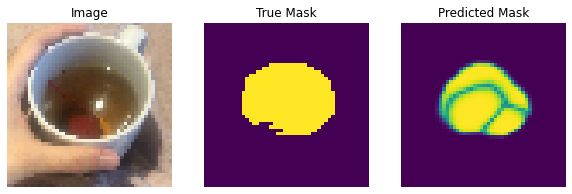

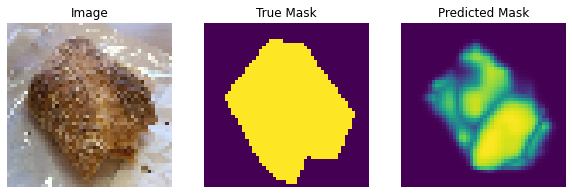

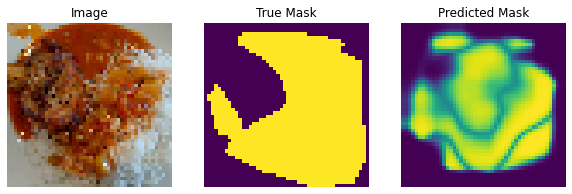

In [20]:
# Visualise the predictions and the true masks
predict(model, test_imgs_path, test_coco, test_classes, IMAGE_SIZE, 3)